1) Loading dataset...
Loaded full file with shape (6362620, 11) in 10.4s

2) Detecting target column...
Detected target column: isFraud

3) Basic cleaning & encoding...
After dropping missing target rows, shape: (6362620, 11)
Numeric columns: 7  Categorical columns: 3
Final feature count: 10 Total rows: 6362620

4) Balancing dataset by undersampling majority class...
Original class counts: Counter({np.int64(0): 6354407, np.int64(1): 8213})
Balanced dataset shape: (16426, 10) new class counts: Counter({np.int64(1): 8213, np.int64(0): 8213})

5) Training scratch Decision Tree (this may take some time for many features)...
Training completed in 24.2s

6) Evaluating on a held-out test split...

Confusion Matrix:
 [[1591   52]
 [   4 1639]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9975    0.9684    0.9827      1643
           1     0.9692    0.9976    0.9832      1643

    accuracy                         0.9830      3286
   macro av

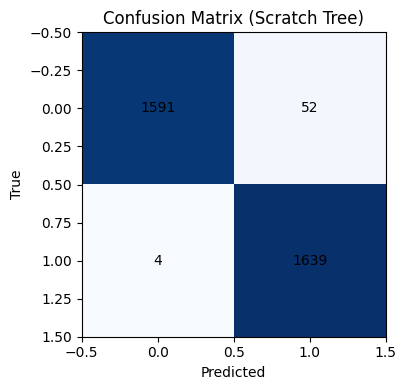

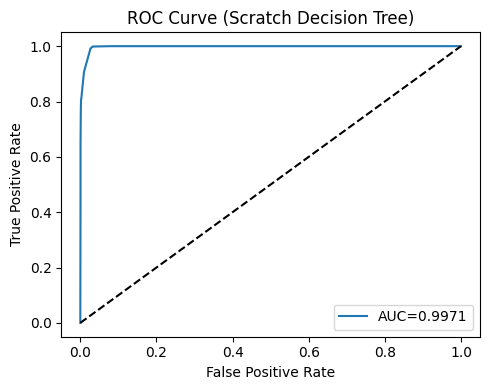


Done.


In [3]:


import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


file_path = r"C:\Users\aparn\Downloads\onlinefraud.csv"   # <--- update if different
target_candidates = ['isFraud', 'fraud', 'target', 'label', 'class']
balance_data = True           
undersample_ratio = 1.0        
max_depth = 6                  
min_samples_split = 5          
random_state = 42


print("1) Loading dataset...")

t0 = time.time()
try:
   
    df = pd.read_csv(file_path, low_memory=False)
    print(f"Loaded full file with shape {df.shape} in {time.time()-t0:.1f}s")
except MemoryError as me:
    print("MemoryError when loading full file. Consider running on a machine with more RAM, or set max_rows to sample.")
    raise
except Exception as e:
    print("Error loading file:", e)
    raise


print("\n2) Detecting target column...")
target_col = None
for c in df.columns:
    if c.lower() in target_candidates:
        target_col = c
        break
if target_col is None:

    for c in df.columns:
        vals = df[c].dropna().unique()
        if len(vals) == 2:
            target_col = c
            break

if target_col is None:
    raise ValueError("Could not find target column automatically. Set `target_col` manually.")

print("Detected target column:", target_col)


print("\n3) Basic cleaning & encoding...")


drop_cols = []
for c in ['PassengerId', 'Name', 'Ticket', 'Cabin']:   
    if c in df.columns:
        drop_cols.append(c)
if drop_cols:
    df = df.drop(columns=drop_cols)


single_uniq_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
if single_uniq_cols:
    print("Dropping single-unique columns:", single_uniq_cols)
    df = df.drop(columns=single_uniq_cols)


df = df.dropna(subset=[target_col])
print("After dropping missing target rows, shape:", df.shape)


if df[target_col].dtype == 'object' or str(df[target_col].dtype).startswith('category'):
    df[target_col] = pd.factorize(df[target_col])[0]


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)
if target_col in cat_cols:
    cat_cols.remove(target_col)

print(f"Numeric columns: {len(num_cols)}  Categorical columns: {len(cat_cols)}")


for c in num_cols:
    median = df[c].median()
    df[c] = df[c].fillna(median)

for c in cat_cols:
    df[c] = df[c].fillna('Missing')
    # convert to integer codes (map)
    df[c] = pd.factorize(df[c])[0]


feature_cols = [c for c in df.columns if c != target_col]
X_df = df[feature_cols]
y = df[target_col].astype(int).values
print("Final feature count:", len(feature_cols), "Total rows:", len(df))


if balance_data:
    print("\n4) Balancing dataset by undersampling majority class...")
    counts = Counter(y)
    print("Original class counts:", counts)

    min_class = min(counts, key=counts.get)
    maj_class = max(counts, key=counts.get)
    n_min = counts[min_class]
    n_maj_keep = int(n_min * undersample_ratio)

   
    idx_min = np.where(y == min_class)[0]
    idx_maj = np.where(y == maj_class)[0]

   
    if n_maj_keep >= len(idx_maj):
        print("Majority class smaller than desired keep size; skipping undersampling.")
    else:
        rng = np.random.RandomState(random_state)
        keep_maj = rng.choice(idx_maj, size=n_maj_keep, replace=False)
        keep_idx = np.concatenate([idx_min, keep_maj])
        # subset the dataframe
        X_df = X_df.iloc[keep_idx].reset_index(drop=True)
        y = y[keep_idx]
        print("Balanced dataset shape:", X_df.shape, "new class counts:", Counter(y))


X = X_df.values


print("\n5) Training scratch Decision Tree (this may take some time for many features)...")
t0 = time.time()

class ScratchDecisionTree:
    def __init__(self, max_depth=6, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree_ = None
        self.feature_gains = None
        self.feature_importances_ = None

    def gini(self, y_sub):
        counts = np.bincount(y_sub)
        probs = counts / len(y_sub)

        if len(probs) == 0:
            return 0.0
        return 1.0 - np.sum(probs ** 2)

    def best_split(self, X_sub, y_sub):
        n_samples, n_features = X_sub.shape
        parent_gini = self.gini(y_sub)
        best_feat, best_thresh, best_gain = None, None, 0.0

        
        for feat in range(n_features):
          
            vals = np.unique(X_sub[:, feat])
            if vals.size <= 1:
                continue
           
            for thresh in vals:
                left_mask = X_sub[:, feat] <= thresh
                right_mask = ~left_mask
                left_count = left_mask.sum()
                right_count = right_mask.sum()
                if left_count < self.min_samples_split or right_count < self.min_samples_split:
                    continue
                g_left = self.gini(y_sub[left_mask])
                g_right = self.gini(y_sub[right_mask])
                weighted_gini = (left_count * g_left + right_count * g_right) / n_samples
                gain = parent_gini - weighted_gini
                if gain > best_gain:
                    best_feat, best_thresh, best_gain = feat, thresh, gain
        return best_feat, best_thresh, best_gain

    def build_tree(self, X_sub, y_sub, depth=0):
        
        if depth >= self.max_depth or len(np.unique(y_sub)) == 1 or len(y_sub) < self.min_samples_split:
            
            val = Counter(y_sub).most_common(1)[0][0]
            
            probs = np.bincount(y_sub, minlength=2) / len(y_sub)
            return {"leaf": True, "value": int(val), "probs": probs}

        feat, thresh, gain = self.best_split(X_sub, y_sub)
        if feat is None:
            val = Counter(y_sub).most_common(1)[0][0]
            probs = np.bincount(y_sub, minlength=2) / len(y_sub)
            return {"leaf": True, "value": int(val), "probs": probs}

        left_mask = X_sub[:, feat] <= thresh
        right_mask = ~left_mask

 
        self.feature_gains[feat] += gain

        node = {
            "leaf": False,
            "feature": int(feat),
            "threshold": float(thresh),
            "left": self.build_tree(X_sub[left_mask], y_sub[left_mask], depth + 1),
            "right": self.build_tree(X_sub[right_mask], y_sub[right_mask], depth + 1)
        }
        return node

    def fit(self, X_arr, y_arr):
        self.feature_gains = np.zeros(X_arr.shape[1], dtype=float)
        self.tree_ = self.build_tree(X_arr, y_arr, depth=0)
        total = self.feature_gains.sum()
        if total > 0:
            self.feature_importances_ = self.feature_gains / total
        else:
            self.feature_importances_ = self.feature_gains.copy()
        return self

    def predict_one(self, x, node=None):
        node = node or self.tree_
        while not node["leaf"]:
            if x[node["feature"]] <= node["threshold"]:
                node = node["left"]
            else:
                node = node["right"]
        return int(node["value"])

    def predict(self, X_arr):
        return np.array([self.predict_one(x) for x in X_arr], dtype=int)

    def predict_proba(self, X_arr):
        probs = []
        for x in X_arr:
            node = self.tree_
            while not node["leaf"]:
                if x[node["feature"]] <= node["threshold"]:
                    node = node["left"]
                else:
                    node = node["right"]
            probs.append(node["probs"])
        return np.vstack(probs)

    def print_tree(self, node=None, feature_names=None, depth=0):
        node = node or self.tree_
        pad = "  " * depth
        if node["leaf"]:
            print(f"{pad}→ Predict {node['value']} (probs={np.round(node['probs'], 3)})")
            return
        fname = feature_names[node["feature"]] if feature_names is not None else f"f{node['feature']}"
        print(f"{pad}[{fname} <= {node['threshold']:.4f}]")
        self.print_tree(node["left"], feature_names, depth + 1)
        print(f"{pad}[{fname} > {node['threshold']:.4f}]")
        self.print_tree(node["right"], feature_names, depth + 1)


tree = ScratchDecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
tree.fit(X, y)

t1 = time.time()
print(f"Training completed in {t1 - t0:.1f}s")


print("\n6) Evaluating on a held-out test split...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

tree = ScratchDecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
probs = tree.predict_proba(X_test)
if probs.shape[1] >= 2:
    y_proba_pos = probs[:, 1]
else:
   
    y_proba_pos = probs[:, 0]

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
auc = None
try:
    auc = roc_auc_score(y_test, y_proba_pos)
    print(f"Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")
except Exception as e:
    print(f"Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    print("AUC could not be computed:", e)


feat_imp = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": tree.feature_importances_
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print("\nTop features by importance:\n", feat_imp.head(15).to_string(index=False))

print("\nReadable decision tree (top levels):\n")
tree.print_tree(feature_names=feature_cols, depth=0)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix (Scratch Tree)")
plt.xlabel("Predicted"); plt.ylabel("True")
for (i,j),val in np.ndenumerate(cm):
    plt.text(j,i,int(val),ha='center',va='center')
plt.tight_layout()
plt.show()

if auc is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_pos)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Scratch Decision Tree)")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nDone.")
